### **ML-Ware'22**

In [2]:
# mounting drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import the dataset from the kaggle

import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [4]:
!kaggle competitions download -c ml-ware22

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.h5.zip: Skipping, found more recently modified local copy (use --force to force download)
test.h5.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# unzipping the train dataset file

!unzip train.h5.zip

Archive:  train.h5.zip
  inflating: train.h5                


In [18]:
import numpy as np
import os
import csv 
from skimage import io, transform
import matplotlib.pyplot as plt

In [1]:
# reading the data file

import h5py
ds = h5py.File('train.h5', 'r')
x = ds['x']
y = ds['y']

In [2]:
x=x[:3000]
y=y[:3000]

In [3]:
# splitting the data in train, test and validate

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32') 

In [4]:
print(x.shape)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(3000, 299, 299, 3)
(1920, 299, 299, 3)
(600, 299, 299, 3)
(480, 299, 299, 3)


### **Proposed Model**

In [16]:
# Import the keras library for adapting the Xception to Regression

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop

In [18]:
# Adapting the Xception architecture to the counting regression problem

from keras.applications.xception import Xception
from keras.models import Model

In [22]:
# Loading the base model

base_model = Xception(weights='imagenet', include_top=True, input_shape=(299,299, 3))
X = base_model.get_layer(index=len(base_model.layers)-2).output
print(X)

KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [23]:
# for adjusting the dim of the model output

X = Dense(1)(X)

In [24]:
model = Model(inputs=base_model.input, outputs=X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [25]:
# compiling the model

opt = RMSprop(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])

In [26]:
# fitting the model on training set with epochs = 50 and lr = 0.001

network_history = model.fit(x_train, y_train, batch_size=16, epochs=50, verbose=1, validation_data= (x_val, y_val))

Epoch 1/50
120/120 [==============================] - 92s 580ms/step - loss: 15.3097 - mse: 15.3097 - val_loss: 17987.7070 - val_mse: 17987.7070
Epoch 2/50
120/120 [==============================] - 71s 588ms/step - loss: 8.9866 - mse: 8.9866 - val_loss: 1317.0647 - val_mse: 1317.0647
Epoch 3/50
120/120 [==============================] - 70s 587ms/step - loss: 6.6329 - mse: 6.6329 - val_loss: 1222.2964 - val_mse: 1222.2964
Epoch 4/50
120/120 [==============================] - 72s 604ms/step - loss: 6.8938 - mse: 6.8938 - val_loss: 4.6597 - val_mse: 4.6597
Epoch 5/50
120/120 [==============================] - 73s 608ms/step - loss: 5.7144 - mse: 5.7144 - val_loss: 27.0110 - val_mse: 27.0110
Epoch 6/50
120/120 [==============================] - 73s 613ms/step - loss: 5.5022 - mse: 5.5022 - val_loss: 15.1326 - val_mse: 15.1326
Epoch 7/50
120/120 [==============================] - 72s 600ms/step - loss: 3.9579 - mse: 3.9579 - val_loss: 142.7227 - val_mse: 142.7227
Epoch 8/50
120/120 [=====

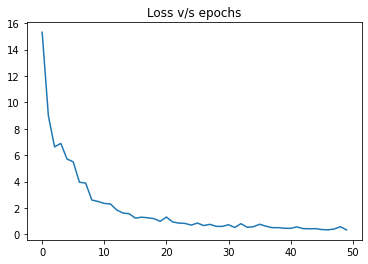

In [29]:
h=network_history.history
plt.plot(h['loss'])
plt.title("Loss v/s epochs")
plt.show()

In [30]:
# saving the trained model on drive

model.save('/content/drive/MyDrive/ML-Ware/MSD_model.h5')
model.save_weights('/content/drive/MyDrive/ML-Ware/MSD_model_weights.h5')

In [5]:
# Loading the trained model

from keras.models import load_model
model = load_model('/content/drive/MyDrive/ML-Ware/MSD_model.h5')

Predict the trained Model

In [6]:
# making prediction on dataset

predictTrain = model.predict(x_train, verbose=1)
predictTrain = predictTrain.reshape(predictTrain.shape[0])

60/60 [==============================] - 23s 219ms/step


In [7]:
predictTest = model.predict(x_test, verbose=1)
predictTest = predictTest.reshape(predictTest.shape[0])

19/19 [==============================] - 6s 280ms/step


In [8]:
predictVal = model.predict(x_val, verbose=1)
predictVal = predictVal.reshape(predictVal.shape[0])

15/15 [==============================] - 3s 226ms/step


## Evaluation

In [9]:
# on train set

from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error

y_true = y_train
predict = predictTrain

r2 = r2_score(y_true, predict)
mae = median_absolute_error(y_true, predict)
mse = mean_squared_error(y_true, predict)
print("MSE \t MAE \t R2")
print(mse, "\t", mae,"\t", r2)

MSE 	 MAE 	 R2
0.6993850923635901 	 0.26515257358551025 	 0.9687206585005405


In [10]:
# on validate set

y_true = y_val
predict = predictVal

r2 = r2_score(y_true, predict)
mae = median_absolute_error(y_true, predict)
mse = mean_squared_error(y_true, predict)
print("MSE \t MAE \t R2")
print(mse, "\t", mae,"\t", r2)

MSE 	 MAE 	 R2
3.4589603770166755 	 0.38637250661849976 	 0.8767568253772065


In [11]:
# on test set

y_true = y_test
predict = predictTest

r2 = r2_score(y_true, predict)
mae = median_absolute_error(y_true, predict)
mse = mean_squared_error(y_true, predict)
print("MSE \t MAE \t R2")
print(mse, "\t", mae,"\t", r2)

MSE 	 MAE 	 R2
1.6950027763574502 	 0.3349609375 	 0.9100099930496501


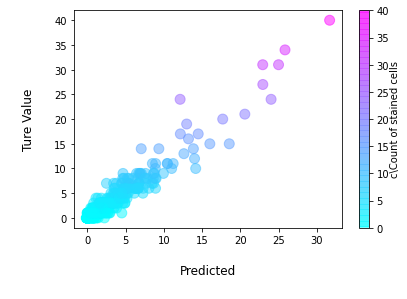

In [13]:
# plotting the Coefficient of Determination
import matplotlib.pyplot as plt

N = y_test.shape
x = predictTest
y = y_test
colors = y_test

area = 100

plt.xlabel("\nPredicted\n", fontsize=12)
plt.ylabel("\nTure Value\n", fontsize=12)

marker_size=15
plt.scatter(x, y, s=area, c=colors, cmap='cool', alpha=0.5)

cbar= plt.colorbar()
cbar.set_label("c\Count of stained cells", labelpad=+1)

plt.show()

## **Predict the Test sample**

In [14]:
# unzipping the test dataset

!unzip test.h5.zip

Archive:  test.h5.zip
  inflating: test.h5                 


In [15]:
# reading the test dataset

import h5py
import pandas as pd
ds_test = h5py.File('test.h5', 'r')
test_x = ds_test['x']

In [16]:
predictTest = model.predict(test_x, verbose=1)
predictTest = predictTest.reshape(predictTest.shape[0])

207/207 [==============================] - 48s 227ms/step


In [19]:
res = np.round(predictTest)

# ignoring the negative predict values 

final = [];
for i in range(len(res)):
  res[i]= max(res[i] , 0)

In [20]:
# Making the Prediction dataframe

for i in range(len(res)):
  final.append([i , res[i]])
df = pd.DataFrame(final, columns=["id", "label"])
df.to_csv('/content/drive/MyDrive/ML-Ware/test_result.csv' , index = False)

In [ ]:
# model implemented by 
# MSD :
# Mayank Singh
# Suhani Agrawal
# Devanshu Agrawal